## PriorCVAE-GP model visualization export tikz

In [1]:
import os
import random
import yaml

from mpl_toolkits.axes_grid1 import make_axes_locatable
import tikzplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn

from priorCVAE.datasets import GPDataset
import priorCVAE.priors as priors
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)


In [2]:
output_dir = "../arc_outputs/gp/qa1qdmjd/"
n = 5000
n_samples_plot = 25
save_tikz = True
output_tik_dir = "outputs/"

In [3]:
ls_list = jnp.array([0.1, 1.0]) #jnp.linspace(0.1, 1, 5)

In [4]:
cfg_path = os.path.join(output_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]["value"]
conditional = cfg_data["conditional"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
kernel = getattr(priors, cfg_data["data_generator"]["value"]["kernel"]["_target_"].split(".")[-1])

x0 = cfg_data["x0"]["value"]
x1 = cfg_data["x1"]["value"]
n_data = cfg_data["n_data"]["value"]

In [5]:
x = jnp.linspace(x0, x1, n_data)

In [6]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [7]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [8]:
kernel_output_name = kernel.__name__.split(".")[-1]

In [9]:
gp_dataset = GPDataset(kernel=kernel(), x=x, sample_lengthscale=False)

## Plot Covariance Prior{C}VAE

<Figure size 640x480 with 0 Axes>

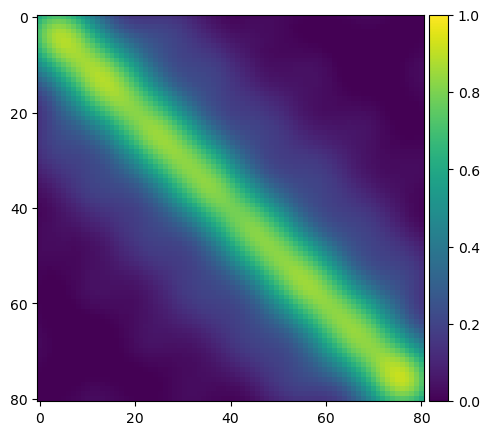

<Figure size 640x480 with 0 Axes>

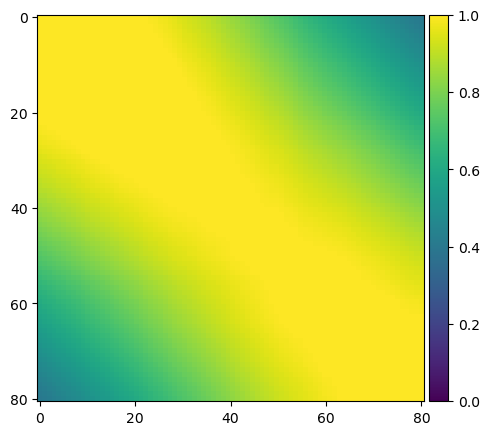

In [10]:
for i, ls in enumerate(ls_list):
    plt.clf()
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = None
    if conditional:
        c = ls*jnp.ones((n, 1))
    
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    vae_cov = jnp.cov(vae_samples.T)
    
    im = axs.imshow(vae_cov, vmin=0, vmax=1)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    axs.set_xticks(jnp.linspace(0, n_data-1, 5))
    axs.set_xticklabels(jnp.linspace(0, n_data, 5, dtype=jnp.int64))

    axs.set_yticks(jnp.linspace(0, n_data-1, 5))
    axs.set_yticklabels(jnp.linspace(0, n_data, 5, dtype=jnp.int64))
    
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    if save_tikz:
        output_fig_path = os.path.join(output_tik_dir, kernel_output_name, f"prior_cvae_cov_{str(ls).replace('.', '_')}.png")
        plt.savefig(output_fig_path)
        
    plt.show()

## Plot Covariance GP

<Figure size 640x480 with 0 Axes>

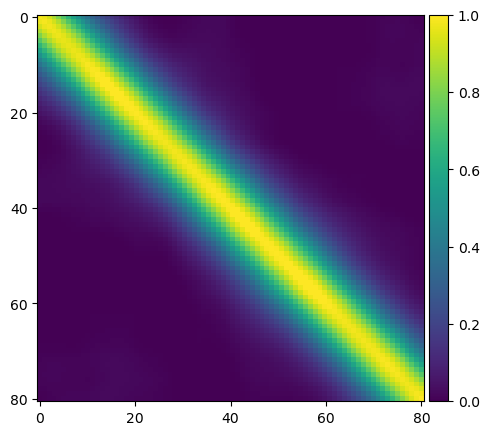

<Figure size 640x480 with 0 Axes>

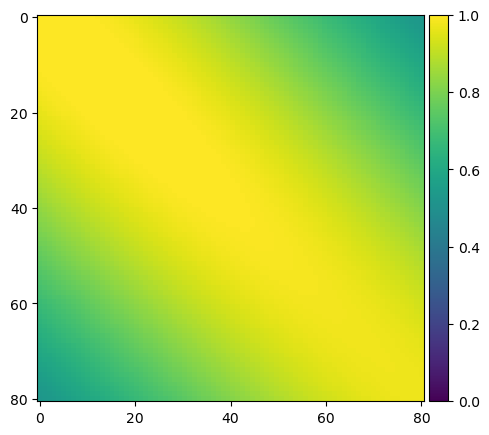

In [11]:
for i, ls in enumerate(ls_list):
    plt.clf()
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    
    gp_dataset.kernel.lengthscale = ls
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    gp_cov = jnp.cov(gp_samples.T)
    
    im = axs.imshow(gp_cov, vmin=0, vmax=1)
    
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    axs.set_xticks(jnp.linspace(0, n_data-1, 5))
    axs.set_xticklabels(jnp.linspace(0, n_data, 5, dtype=jnp.int64))

    axs.set_yticks(jnp.linspace(0, n_data-1, 5))
    axs.set_yticklabels(jnp.linspace(0, n_data, 5, dtype=jnp.int64))
    
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    
    if save_tikz:
        output_fig_path = os.path.join(output_tik_dir, kernel_output_name, 
                                       f"gp_cov_{str(ls).replace('.', '_')}.png")
        plt.savefig(output_fig_path)
        
    plt.show()

## Plot Samples for PriorCVAE

<Figure size 640x480 with 0 Axes>

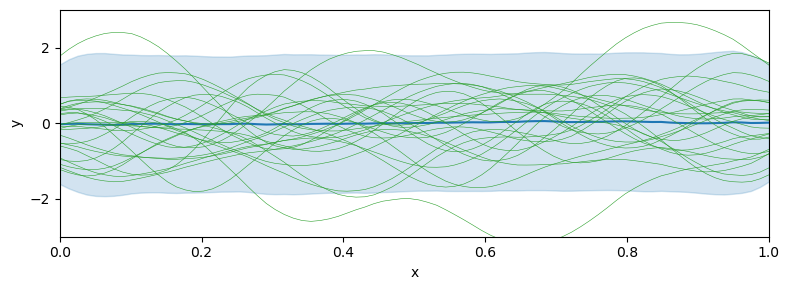

<Figure size 640x480 with 0 Axes>

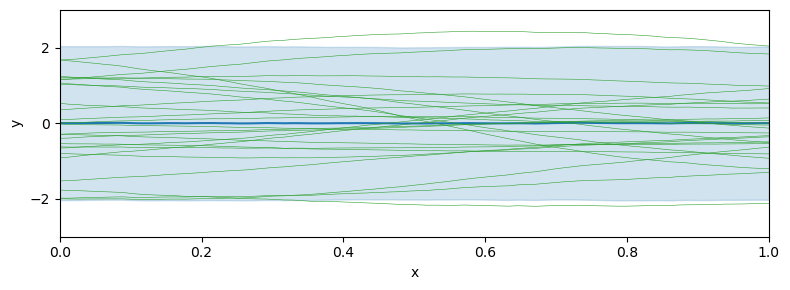

In [12]:
for i, ls in enumerate(ls_list):
    
    plt.clf()
    fig, axs = plt.subplots(1, 1, figsize=(8, 3))
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = None
    if conditional:
        c = ls*jnp.ones((n, 1))
    
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    vae_samples_mean = jnp.mean(vae_samples, axis=0)
    vae_samples_std = jnp.std(vae_samples, axis=0)
    
    plt.plot(x, vae_samples_mean, c="tab:blue", label="Mean")
    plt.fill_between(x, vae_samples_mean - 2 * vae_samples_std, 
                                 vae_samples_mean + 2 * vae_samples_std, color="tab:blue", alpha=0.2, 
                     label="Confidence Interval")
    for v in vae_samples[:n_samples_plot]:
        plt.plot(x, v, c="tab:green", linewidth=0.4)
    
    plt.plot(-5, -5, c="tab:green", linewidth=0.4, label="Samples")
    plt.ylim([-3, 3])
    plt.xlim([x[0], x[-1]])
    plt.yticks([-2, 0 , 2])
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.tight_layout()
    
    if save_tikz:
        output_tik_path = os.path.join(output_tik_dir, kernel_output_name, f"prior_cvae_samples_{str(ls).replace('.', '_')}.tex")
        tikzplotlib.save(output_tik_path,
                         figurewidth='\\figurewidth', figureheight='\\figureheight',
                         tex_relative_path_to_data='fig/',
                         figure=fig)
    
    plt.show()

## Plot Samples for GP

<Figure size 640x480 with 0 Axes>

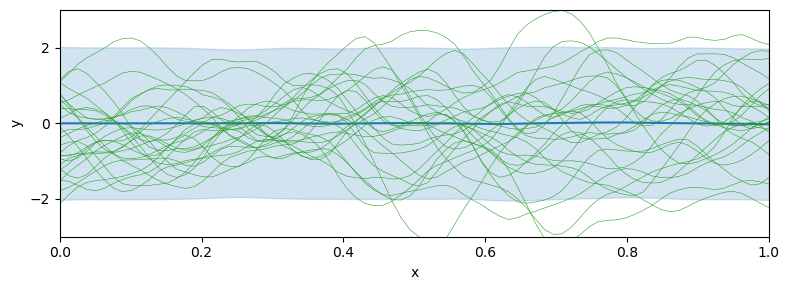

<Figure size 640x480 with 0 Axes>

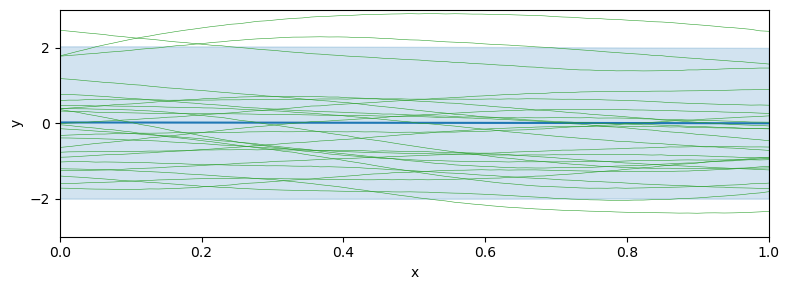

In [13]:
for i, ls in enumerate(ls_list):
    
    plt.clf()
    fig, axs = plt.subplots(1, 1, figsize=(8, 3))
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = None
    if conditional:
        c = ls*jnp.ones((n, 1))
    
    gp_dataset.kernel.lengthscale = ls
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    gp_samples_mean = jnp.mean(gp_samples, axis=0)
    gp_samples_std = jnp.std(gp_samples, axis=0)
    
    plt.plot(x, gp_samples_mean, c="tab:blue", label="Mean")
    plt.fill_between(x, gp_samples_mean - 2 * gp_samples_std, 
                                 gp_samples_mean + 2 * gp_samples_std, color="tab:blue", alpha=0.2, 
                     label="Confidence Interval")
    for v in gp_samples[:n_samples_plot]:
        plt.plot(x, v, c="tab:green", linewidth=0.4)
    
    plt.plot(-5, -5, c="tab:green", linewidth=0.4, label="Samples")
    plt.ylim([-3, 3])
    plt.xlim([x[0], x[-1]])
    plt.yticks([-2, 0 , 2])
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.tight_layout()
    
    if save_tikz:
        output_tik_path = os.path.join(output_tik_dir, kernel_output_name, f"gp_samples_{str(ls).replace('.', '_')}.tex")
        tikzplotlib.save(output_tik_path,
                         figurewidth='\\figurewidth', figureheight='\\figureheight',
                         tex_relative_path_to_data='fig/',
                         figure=fig)
    
    plt.show()